In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

In [41]:
df = pd.read_csv('/Users/baptistecarbillet/Documents/MachineLearning1/winequality-white.csv',sep=';')

# Preprocessing

Binary classification problem : 1 (good quality) or 0 (bad quality). Good quality wine are those with a quality score of 7 or higher.

In [42]:
df['y'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)
df = df.drop('quality',axis=1)

In [43]:
#percentage of good wine
print('Percentage of good wine : ',df['y'].mean())

Percentage of good wine :  0.21641486320947326


Split between training and test set. I choose a 80/20 split.

In [44]:
X,y = np.array(df.drop('y',axis=1)),np.array(df['y'])

In [45]:
from sklearn.model_selection import train_test_split

random_state = 75 #Paris

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3918, 11), (980, 11), (3918,), (980,))

We split the train set into 5 folds to do cross validation.

In [46]:
from sklearn.model_selection import KFold, cross_validate

In [47]:
from sklearn.model_selection import KFold, cross_validate
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

model = tree.DecisionTreeClassifier(random_state=random_state)
scoring=('f1')

cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)

for i in range(n_splits):
    print('Fold',i+1)
    print('Train accuracy:',cv_results['train_score'][i])
    print('Test accuracy:',cv_results['test_score'][i])
    print('Depth:',cv_results['estimator'][i].get_depth())
    print('')



Fold 1
Train accuracy: 1.0
Test accuracy: 0.608695652173913
Depth: 22

Fold 2
Train accuracy: 1.0
Test accuracy: 0.622478386167147
Depth: 16

Fold 3
Train accuracy: 1.0
Test accuracy: 0.5865102639296187
Depth: 19

Fold 4
Train accuracy: 1.0
Test accuracy: 0.5552238805970149
Depth: 23

Fold 5
Train accuracy: 1.0
Test accuracy: 0.5925925925925926
Depth: 22



There is a max Depth of 23 across the five different trees.

### Testing prepruning of DT.

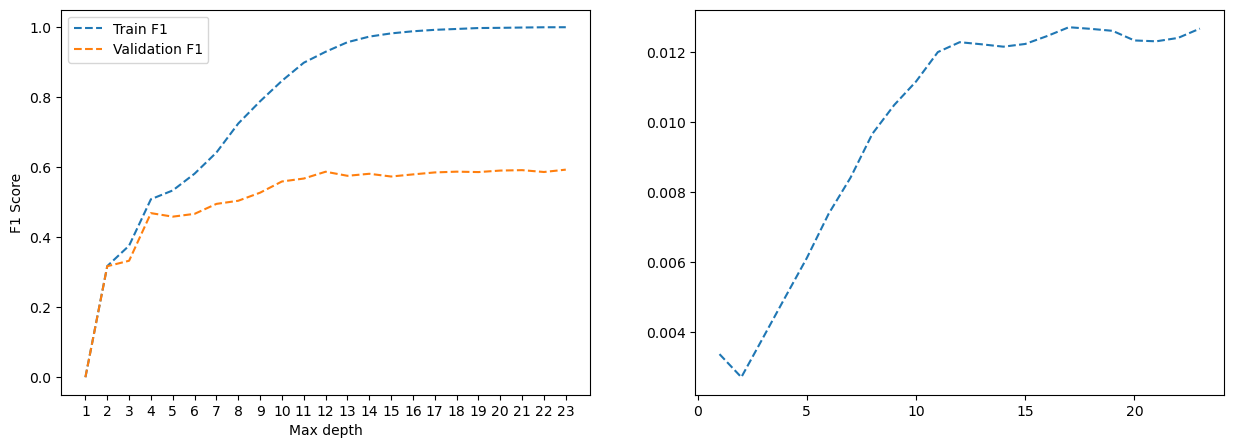

In [79]:
max_depth = [d for d in range(1,24)]
train_accuracy = []
test_accuracy = []
fit_time = []
fitted_depth = np.zeros((len(max_depth),n_splits))

fit_std = []

for d in max_depth:
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

    model = tree.DecisionTreeClassifier(max_depth=d,random_state=random_state)
    scoring=('f1')

    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_accuracy.append(np.mean(cv_results['train_score']))
    test_accuracy.append(np.mean(cv_results['test_score']))
    
    fit_std.append(np.std(cv_results['test_score']))
    
    #add depth of each tree
    
    for i in range(n_splits):
        fitted_depth[d-1,i] = cv_results['estimator'][i].get_depth()
    
    fit_time.append(np.mean(cv_results['fit_time']))
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(max_depth,train_accuracy,label='Train F1',linestyle='--')
##With dashed line
ax[0].plot(max_depth,test_accuracy,label='Validation F1',linestyle='--')
ax[0].set_xlabel('Max depth')
ax[0].set_ylabel('F1 Score')
ax[0].set_xticks(max_depth)
ax[0].legend()

ax[1].plot(max_depth,fit_time,label='Fit time',linestyle='--')

plt.show()
    
    

    

In [49]:
#print best depth and best score

best_depth = max_depth[np.argmax(test_accuracy)]
best_score = max(test_accuracy)

print('Best depth:',best_depth)
print('Best score:',best_score)

Best depth: 23
Best score: 0.5931001550920572


In [50]:
model = tree.DecisionTreeClassifier(max_depth = 23,random_state=random_state)
#plot tree
model.fit(X_train,y_train)
fig = plt.figure(figsize=(25,20))
#tree.plot_tree(model,fontsize=8,feature_names=df.drop('y',axis=1).columns.to_list(),class_names=['Bad','Good'])

#Plot tree on fig
#tree.plot_tree(model,fontsize=9,feature_names=df.drop('y',axis=1).columns.to_list(),class_names=['Bad','Good'],ax=plt.gca())


<Figure size 2500x2000 with 0 Axes>

In [142]:
#plot model tree with graphviz
import graphviz
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=df.drop('y',axis=1).columns.to_list(),  
                      class_names=['Bad','Good'],  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('tree',view=True)

'tree.pdf'

Question : why is the val loss not decreasing????

In [51]:
#Here using the decision tree structure I get the depth of each nodes in the tree
#Code is taken from scikit learn documentation
#https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
feature = model.tree_.feature
threshold = model.tree_.threshold
values = model.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True




In [52]:
## Create a dictionary with depth as key and nodes as values (in a list)
depth_nodes = {}

for i in range(n_nodes):
    if node_depth[i] in depth_nodes.keys():
        depth_nodes[node_depth[i]].append(i)
    else:
        depth_nodes[node_depth[i]] = [i]
    

In [53]:
# for depth in range(1,24):
#print the number of nodes below a certain depth

for depth in range(1,24):
    print('Percentage of nodes below depth',depth,':',np.sum([len(depth_nodes[d]) for d in range(depth,20)])/n_nodes)

Percentage of nodes below depth 1 : 0.9966555183946488
Percentage of nodes below depth 2 : 0.9944258639910813
Percentage of nodes below depth 3 : 0.9899665551839465
Percentage of nodes below depth 4 : 0.9810479375696767
Percentage of nodes below depth 5 : 0.9632107023411371
Percentage of nodes below depth 6 : 0.9297658862876255
Percentage of nodes below depth 7 : 0.882943143812709
Percentage of nodes below depth 8 : 0.8115942028985508
Percentage of nodes below depth 9 : 0.7090301003344481
Percentage of nodes below depth 10 : 0.5752508361204013
Percentage of nodes below depth 11 : 0.4169453734671126
Percentage of nodes below depth 12 : 0.2809364548494983
Percentage of nodes below depth 13 : 0.16945373467112598
Percentage of nodes below depth 14 : 0.10256410256410256
Percentage of nodes below depth 15 : 0.06243032329988852
Percentage of nodes below depth 16 : 0.03567447045707915
Percentage of nodes below depth 17 : 0.01560758082497213
Percentage of nodes below depth 18 : 0.00891861761426

In [173]:
for d in range(0,20):
    print('Percentage of sample that reach depth d',d,':',np.sum([np.sum(values[n]) for n in depth_nodes[d]])/3918)


Percentage of sample that reach depth d 0 : 1.0
Percentage of sample that reach depth d 1 : 1.0
Percentage of sample that reach depth d 2 : 1.0
Percentage of sample that reach depth d 3 : 1.0
Percentage of sample that reach depth d 4 : 1.0
Percentage of sample that reach depth d 5 : 0.9964267483409903
Percentage of sample that reach depth d 6 : 0.9754977029096478
Percentage of sample that reach depth d 7 : 0.9612046962736089
Percentage of sample that reach depth d 8 : 0.9150076569678407
Percentage of sample that reach depth d 9 : 0.6556916794282798
Percentage of sample that reach depth d 10 : 0.5091883614088821
Percentage of sample that reach depth d 11 : 0.3721286370597244
Percentage of sample that reach depth d 12 : 0.2613578356304237
Percentage of sample that reach depth d 13 : 0.16794282797345583
Percentage of sample that reach depth d 14 : 0.1082184788157223
Percentage of sample that reach depth d 15 : 0.055640632976008166
Percentage of sample that reach depth d 16 : 0.02399183256

50 % of values are classified at depth = 10

### Testing postpruning of DT.

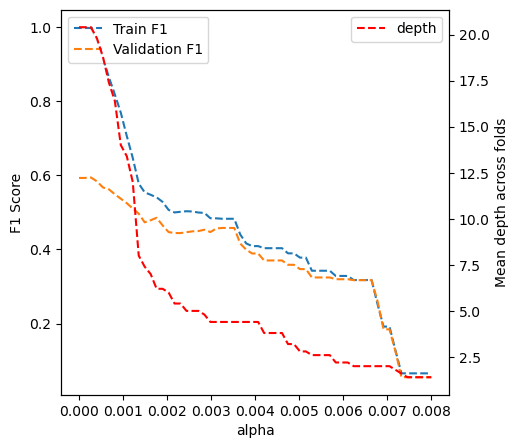

In [99]:
train_accuracy = []
test_accuracy = []
depth = []
fit_time = []

alpha_list = np.linspace(0,0.008,60)

for alpha in alpha_list:
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

    model = tree.DecisionTreeClassifier(ccp_alpha= alpha,random_state=random_state)
    scoring=('f1')

    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_accuracy.append(np.mean(cv_results['train_score']))
    test_accuracy.append(np.mean(cv_results['test_score']))
    fit_time.append(np.mean(cv_results['fit_time']))
    depth.append(np.mean([estimator.get_depth() for estimator in cv_results['estimator']]))

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(alpha_list,train_accuracy,label='Train F1',linestyle='--')
##With dashed line
ax.plot(alpha_list,test_accuracy,label='Validation F1',linestyle='--')
ax.set_xlabel('alpha')
ax.set_ylabel('F1 Score')

ax.legend(loc = 'upper left')

#set second axis on the right for max depth and add mean depth to the plot
ax2 = ax.twinx()
ax2.plot(alpha_list,depth,label='depth',linestyle='--',color='red')
ax2.set_ylabel('Mean depth across folds')
ax2.legend(loc='upper right')




plt.show()

In [98]:
print('Best alpha : ',alpha_list[np.argmax(test_accuracy)])
print('Best test accuracy : ',np.max(test_accuracy))
print('Best train accuracy : ',train_accuracy[np.argmax(test_accuracy)])
print('Mean depth : ',depth[np.argmax(test_accuracy)])
best_alpha = alpha_list[np.argmax(test_accuracy)]


Best alpha :  0.0
Best test accuracy :  0.5931001550920572
Best train accuracy :  1.0
Mean depth :  20.4


In [95]:
#test_accuracy.reverse()
train_accuracy.reverse()

Combination of both : Does this alpha value improves the result when we combine it with prepruning ?

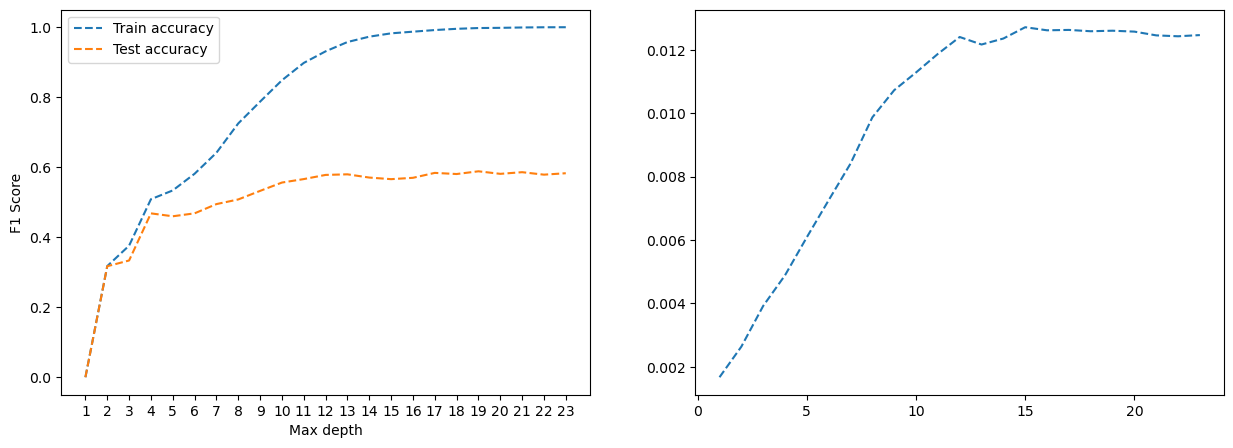

In [56]:
max_depth = [d for d in range(1,24)]
train_accuracy = []
test_accuracy = []
fit_time = []


for d in max_depth:
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

    model = tree.DecisionTreeClassifier(max_depth=d,ccp_alpha=best_alpha)
    scoring=('f1')

    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_accuracy.append(np.mean(cv_results['train_score']))
    test_accuracy.append(np.mean(cv_results['test_score']))
    
    fit_time.append(np.mean(cv_results['fit_time']))
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(max_depth,train_accuracy,label='Train accuracy',linestyle='--')
##With dashed line
ax[0].plot(max_depth,test_accuracy,label='Test accuracy',linestyle='--')
ax[0].set_xlabel('Max depth')
ax[0].set_ylabel('F1 Score')
ax[0].set_xticks(max_depth)
ax[0].legend()

ax[1].plot(max_depth,fit_time,label='Fit time',linestyle='--')

plt.show()

### grid search for trees

In [57]:
from sklearn.model_selection import GridSearchCV
decisionT_param = {'max_depth':[d for d in range(1,20)],
                   'splitter':['best','random'],
                     'criterion':['gini','entropy'],
                     'min_samples_split':[1,0.01,0.05,0.1,0.2,0.3,0.4,0.5],
                     'class_weight':['balanced',{0:1/8,1:1/2}],
                     
                }

grid = GridSearchCV(tree.DecisionTreeClassifier(random_state=random_state),decisionT_param,scoring='f1',cv=5)

grid.fit(X_train,y_train)

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
760 fits failed out of a total of 6080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
760 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=75),
             param_grid={'class_weight': ['balanced', {0: 0.125, 1: 0.5}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [1, 0.01, 0.05, 0.1, 0.2, 0.3,
                                               0.4, 0.5],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [58]:
grid.best_params_

{'class_weight': {0: 0.125, 1: 0.5},
 'criterion': 'gini',
 'max_depth': 14,
 'min_samples_split': 0.01,
 'splitter': 'best'}

In [59]:
grid.best_score_

0.5686801072115657

Learning curve

In [60]:
X_train_lc,X_val_lc,y_train_lc,y_val_lc = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)
#model with best parameters
model = tree.DecisionTreeClassifier(**grid.best_params_)
model.fit(X_train_lc,y_train_lc)

#Select a sample of X_train, with the corresponding y_train
train_acc_lc = []
val_acc_lc = []

from sklearn.metrics import f1_score
for sample in np.linspace(0.01,0.99,98):
    X_train_sample,X_out_sample,y_train_sample,y_out_sample = train_test_split(X_train_lc,y_train_lc,test_size=float(1 - sample),random_state=random_state)
    
    model = tree.DecisionTreeClassifier(**grid.best_params_)
    model.fit(X_train_sample,y_train_sample)
    
    y_pred = model.predict(X_val_lc)
    #Train accuracy
    y_pred_train = model.predict(X_train_sample)
    train_acc_lc.append(f1_score(y_train_sample,y_pred_train))
    
    #Validation accuracy
    val_acc_lc.append(f1_score(y_val_lc,y_pred))
    

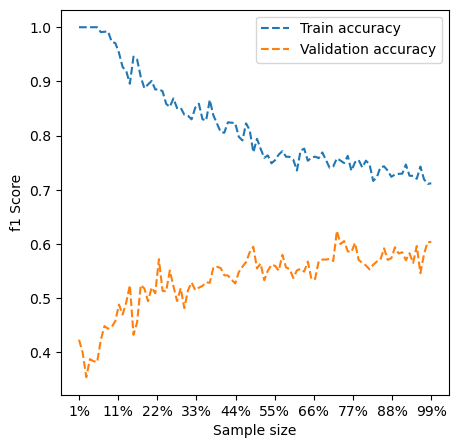

In [61]:




fig, ax = plt.subplots(figsize=(5,5))

ax.plot(np.linspace(0.01,0.99,98),train_acc_lc,label='Train accuracy',linestyle='--')
##With dashed line

ax.plot(np.linspace(0.01,0.99,98),val_acc_lc,label='Validation accuracy',linestyle='--')

ax.set_xlabel('Sample size')
ax.set_ylabel('f1 Score')
#x_tick as percentage
ax.set_xticks(np.linspace(0.01,0.99,10))
ax.set_xticklabels([str(int(i*100))+'%' for i in np.linspace(0.01,0.99,10)])
ax.legend()

plt.show()

### Get classification depth on val score

In [62]:
modelOverfitted = tree.DecisionTreeClassifier(random_state=random_state)
modelOverfitted.fit(X_train_lc,y_train_lc)

DecisionTreeClassifier(random_state=75)

In [63]:
modelOverfitted.get_depth()

22

In [64]:
node_indicator = modelOverfitted.decision_path(X_val_lc)

In [66]:
n_nodes = modelOverfitted.tree_.node_count
children_left = modelOverfitted.tree_.children_left
children_right = modelOverfitted.tree_.children_right
feature = modelOverfitted.tree_.feature
threshold = modelOverfitted.tree_.threshold
values = modelOverfitted.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True


In [67]:
#last_depth contains the last depth of each sample
last_depth = np.zeros(X_val_lc.shape[0])

for i in range(X_val_lc.shape[0]):
    ind = node_indicator[i].indices.tolist()
    
    for x in ind:
        if is_leaves[x]:
            last_depth[i] = node_depth[x]
            break
    

In [68]:
np.quantile(np.array(last_depth),(np.linspace(0,1,11)))

#80% of nodes are classified by depth = 12

array([ 4.,  7.,  8.,  8.,  9.,  9., 10., 11., 11., 13., 22.])

Get score on test

In [70]:

model = tree.DecisionTreeClassifier(**grid.best_params_)
model.fit(X_train,y_train)
model.predict(X_test)

f1_score(y_test,model.predict(X_test))

0.5797598627787307